# LSTM Price Prediction (v3)

Import packages and load market data; technical indicators are computed in this notebook (not from DB).

Run the import and data-load cells below, then proceed through Data Quality checks and normalization.

In [1]:
"""
Setup and Imports
"""
import sys
from pathlib import Path
from datetime import datetime, timedelta, timezone
from typing import Tuple, Optional
import warnings
warnings.filterwarnings('ignore')

# Add project root to path
project_root = Path().resolve().parent
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

# Load environment variables from .env file
from dotenv import load_dotenv
env_path = project_root / ".env"
if env_path.exists():
    load_dotenv(env_path)
    print(f"Loaded environment variables from: {env_path}")
else:
    print(f"Warning: .env file not found at {env_path}")
    print("Please ensure your database credentials are set in environment variables or .env file")

# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# PyTorch Forecasting (encoder-only scaling, no look-ahead bias)
from pytorch_forecasting import TimeSeriesDataSet
from pytorch_forecasting.data.encoders import EncoderNormalizer
from pytorch_forecasting import TemporalFusionTransformer
from pytorch_forecasting.metrics import QuantileLoss
import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor

# optuna
import optuna

# Database
from sqlalchemy import select, desc
from src.shared.database.base import db_readonly_session
from src.shared.database.models.market_data import MarketData

# Yahoo Finance (for direct OHLCV fetch in notebook)
import yfinance as yf

# statsmodel
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox

from captum.attr import IntegratedGradients
import matplotlib.pyplot as plt
import shap

Loaded environment variables from: D:\PythonProjects\Trading-System\.env


In [2]:
# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)

# Set random seeds for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(RANDOM_SEED)
    torch.backends.cudnn.deterministic = True

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")
    torch.set_float32_matmul_precision("medium")  # use Tensor Cores on RTX 3050 (medium = speed vs precision)

PyTorch version: 2.7.0+cu128
CUDA available: True
CUDA device: NVIDIA GeForce RTX 3050 Laptop GPU


## Helper functions

In [3]:
# Helper functions for inverse transformation (convert predictions back to prices)

def inverse_transform_pct_return(predictions: np.ndarray, base_prices: np.ndarray) -> np.ndarray:
    """
    Convert percentage return predictions back to price predictions.
    
    Args:
        predictions: Predicted percentage returns
        base_prices: Base prices (typically previous period's close prices)
        
    Returns:
        Predicted prices
    """
    return base_prices * (1 + predictions)


def inverse_transform_log_return(predictions: np.ndarray, base_prices: np.ndarray) -> np.ndarray:
    """
    Convert log return predictions back to price predictions.
    
    Args:
        predictions: Predicted log returns
        base_prices: Base prices (typically previous period's close prices)
        
    Returns:
        Predicted prices
    """
    return base_prices * np.exp(predictions)

print("Inverse transformation functions defined:")
print("  - inverse_transform_pct_return(): Convert % returns → prices")
print("  - inverse_transform_log_return(): Convert log returns → prices")

Inverse transformation functions defined:
  - inverse_transform_pct_return(): Convert % returns → prices
  - inverse_transform_log_return(): Convert log returns → prices


# Data Preparation

## Load OHLC Data

In [4]:
def load_market_data(
    symbol: str,
    start_date: Optional[datetime] = None,
    end_date: Optional[datetime] = None,
    data_source: str = "yahoo_adjusted",
    min_records: int = 1000
) -> pd.DataFrame:
    """
    Load OHLCV market data from database for a specific symbol.
    Default data_source='yahoo_adjusted' (splits/dividends adjusted). Use 'yahoo' for raw.
    Technical indicators are computed in this notebook, not loaded from DB.
    
    Args:
        symbol: Stock symbol (e.g., 'AAPL')
        start_date: Start date (default: 1 year ago)
        end_date: End date (default: today)
        data_source: Data source ('yahoo_adjusted', 'yahoo', 'polygon', 'alpaca')
        min_records: Minimum number of records required
        
    Returns:
        DataFrame with OHLCV columns (timestamp, open, high, low, close, volume)
    """
    if start_date is None:
        start_date = datetime.now(timezone.utc) - timedelta(days=500)
    if end_date is None:
        end_date = datetime.now(timezone.utc)
    
    symbol_upper = symbol.upper()
    
    # Load market data
    with db_readonly_session() as session:
        # Query market data
        market_query = (
            select(MarketData)
            .where(MarketData.symbol == symbol_upper)
            .where(MarketData.data_source == data_source.lower())
            .where(MarketData.timestamp >= start_date)
            .where(MarketData.timestamp <= end_date)
            .order_by(MarketData.timestamp)
        )
        
        market_result = session.execute(market_query)
        market_records = market_result.scalars().all()
    
    if len(market_records) < min_records:
        raise ValueError(
            f"Insufficient data: {len(market_records)} records found, "
            f"minimum {min_records} required"
        )
    
    # Convert market data to DataFrame
    market_data = []
    for record in market_records:
        if record.is_complete:  # Only include complete OHLCV records
            market_data.append({
                'timestamp': record.timestamp,
                'open': float(record.open),
                'high': float(record.high),
                'low': float(record.low),
                'close': float(record.close),
                'volume': int(record.volume) if record.volume else 0,
            })
    
    df_market = pd.DataFrame(market_data)
    return df_market

In [5]:
# Optional: verify where market_data lives in the DB you're connected to.
# Run this if DB load fails with "relation does not exist". Expect: schema=data_ingestion, table_name=market_data.
from sqlalchemy import text
try:
    with db_readonly_session() as session:
        r = session.execute(text(
            "SELECT table_schema, table_name FROM information_schema.tables WHERE table_name = 'market_data'"
        )).fetchall()
    if r:
        print("market_data found:", [dict(zip(["schema", "table"], row)) for row in r])
    else:
        print("No table named 'market_data' in this database. Create it with scripts/01_create_databases.sql and 02_create_core_tables.sql.")
except Exception as e:
    print("Could not check DB:", e)

2026-02-09 16:50:19.716 | DEBUG    | src.shared.database.base:db_readonly_session:156 - Read-only session completed successfully


market_data found: [{'schema': 'data_ingestion', 'table': 'market_data'}]


In [6]:
def fetch_market_data_yahoo(
    symbol: str,
    start_date: Optional[datetime] = None,
    end_date: Optional[datetime] = None,
    interval: str = "1h",
) -> pd.DataFrame:
    """
    Fetch OHLCV from Yahoo Finance (yfinance). No DB required.
    Uses auto_adjust=True so prices are adjusted for splits/dividends.
    Yahoo limits 1h data to the last 730 days; keep start_date within that range.
    Returns DataFrame with columns: timestamp, open, high, low, close, volume (UTC).
    """
    if start_date is None:
        start_date = datetime.now(timezone.utc) - timedelta(days=365)
    if end_date is None:
        end_date = datetime.now(timezone.utc)
    start = start_date.date() if hasattr(start_date, "date") else start_date
    end = end_date.date() if hasattr(end_date, "date") else end_date
    ticker = yf.Ticker(symbol.upper())
    hist = ticker.history(start=start, end=end, interval=interval, auto_adjust=True)
    if hist.empty:
        raise ValueError(f"No data from Yahoo for {symbol} between {start} and {end}")
    hist = hist.rename(columns={"Open": "open", "High": "high", "Low": "low", "Close": "close", "Volume": "volume"})
    hist = hist[["open", "high", "low", "close", "volume"]]
    hist.index = pd.to_datetime(hist.index)
    if hist.index.tz is None:
        hist.index = hist.index.tz_localize("UTC", ambiguous="infer")
    else:
        hist.index = hist.index.tz_convert("UTC")
    hist["timestamp"] = hist.index
    df_market = hist.reset_index(drop=True)[["timestamp", "open", "high", "low", "close", "volume"]]
    df_market["volume"] = df_market["volume"].fillna(0).astype(int)
    return df_market

In [7]:
# Load OHLCV: try DB (yahoo_adjusted) first, else fetch from Yahoo directly (1h; 730-day limit).
# DB table must be data_ingestion.market_data in the DB from .env (TRADING_DB_NAME). Run the cell above to verify.
SYMBOL = "MU"
START_DATE = datetime.now(timezone.utc) - timedelta(days=720)
try:
    df_market = load_market_data(SYMBOL, start_date=START_DATE, data_source="yahoo_adjusted", min_records=100)
    print("Loaded from DB (yahoo_adjusted)")
except Exception:
    print("DB unavailable or insufficient data (e.g. table missing). Loading from Yahoo...")
    df_market = fetch_market_data_yahoo(SYMBOL, start_date=START_DATE)
    print("Loaded from Yahoo (yfinance)")



2026-02-09 16:50:19.803 | DEBUG    | src.shared.database.base:db_readonly_session:156 - Read-only session completed successfully


Loaded from DB (yahoo_adjusted)


In [8]:
print("Date range:", df_market["timestamp"].min(), "to", df_market["timestamp"].max())

Date range: 2024-02-21 03:30:00-06:00 to 2026-02-09 09:30:00-06:00


## Outlier Detection

**Handling "Wick" Outliers** (The "Flash Crash" Problem) Even with auto_adjust=True, Yahoo Finance can occasionally have "bad prints"—data points where the High or Low is unnaturally far from the Open/Close. To protect your PyTorch model from these without deleting data, use a Clipping strategy before passing it to the normalizer. This prevents a single bad data point from skewing the local \(\mu \) and \(\sigma \) of your window. 

## Data Quality & Sanity Checks

Yahoo Finance can contain bad prints and holiday gaps that break time-series. Run these checks after loading `df_market`:

- **OHLC logical consistency**: High ≥ Open, High ≥ Close, Low ≤ Open, Low ≤ Close.
- **Zero volume**: Rows with zero volume often indicate data errors.

In [9]:
# --- 1. OHLC Logical Consistency ---
# High >= Open, High >= Close, Low <= Open, Low <= Close
viol_high_ge_open = (df_market["high"] < df_market["open"])
viol_high_ge_close = (df_market["high"] < df_market["close"])
viol_low_le_open = (df_market["low"] > df_market["open"])
viol_low_le_close = (df_market["low"] > df_market["close"])
bad_ohlc = viol_high_ge_open | viol_high_ge_close | viol_low_le_open | viol_low_le_close
n_bad_ohlc = bad_ohlc.sum()
print("OHLC logical consistency:")
print(f"  Rows violating High>=Open: {viol_high_ge_open.sum()}, High>=Close: {viol_high_ge_close.sum()}, Low<=Open: {viol_low_le_open.sum()}, Low<=Close: {viol_low_le_close.sum()}")
print(f"  Total rows with any OHLC violation: {n_bad_ohlc}")
if n_bad_ohlc > 0:
    display(df_market.loc[bad_ohlc].head(10).style.set_caption("Sample: rows with OHLC violations"))



# --- 3. Zero volume check ---
zero_vol = (df_market["volume"] == 0)
n_zero = zero_vol.sum()
print("\nZero volume:")
print(f"  Rows with volume == 0: {n_zero} ({100 * n_zero / len(df_market):.2f}%)")
if n_zero > 0:
    display(df_market.loc[zero_vol].head(10).style.set_caption("Sample: rows with zero volume"))

OHLC logical consistency:
  Rows violating High>=Open: 0, High>=Close: 0, Low<=Open: 0, Low<=Close: 0
  Total rows with any OHLC violation: 0

Zero volume:
  Rows with volume == 0: 2 (0.06%)


,timestamp,open,high,low,close,volume
57,2024-03-04 04:30:00-06:00,95.650000,96.950000,95.610000,96.680000,0
65,2024-03-05 05:30:00-06:00,94.410000,94.490000,94.110000,94.350000,0


In [10]:
df_market.head(5)

,timestamp,open,high,low,close,volume
0,2024-02-21 03:30:00-06:00,80.79,81.23,79.940,80.405,1640356
1,2024-02-21 04:30:00-06:00,80.40,80.70,80.195,80.345,1182769
2,2024-02-21 05:30:00-06:00,80.34,80.49,80.115,80.390,761086
3,2024-02-21 06:30:00-06:00,80.40,80.77,80.360,80.575,681732
4,2024-02-21 07:30:00-06:00,80.58,80.68,80.170,80.365,793658


## How to handle bad rows

**OHLC violations** (High &lt; Open/Close or Low &gt; Open/Close):
- **Drop:** Remove rows with any violation (simple; you lose those bars).
- **Repair:** Fix in place: set `high = max(open, high, close)` and `low = min(open, low, close)` so the bar is logically consistent with minimal change. Use when violations are rare and likely bad prints.

**Zero volume:**
- **Drop:** Remove rows with `volume == 0` (often data errors; avoids zero in ratios).
- **Keep:** Leave as-is (some bars can be genuinely zero; model sees them).

Run the cell below to apply your choice; then re-run the wick clipping and later steps on the cleaned `df_market`.

In [11]:
# Choose how to handle bad rows (run the Data Quality cell above first to see counts)
DROP_OHLC_VIOLATIONS = False   # True: drop rows that fail OHLC consistency
REPAIR_OHLC_IN_PLACE = True    # True: fix high/low so High >= max(O,C), Low <= min(O,L,C); use when violations are rare
DROP_ZERO_VOLUME = False       # True: drop rows with volume == 0

n_before = len(df_market)
bad_ohlc = (
    (df_market["high"] < df_market["open"])
    | (df_market["high"] < df_market["close"])
    | (df_market["low"] > df_market["open"])
    | (df_market["low"] > df_market["close"])
)
zero_vol = df_market["volume"] == 0

if REPAIR_OHLC_IN_PLACE and bad_ohlc.any():
    df_market = df_market.copy()
    df_market.loc[bad_ohlc, "high"] = df_market.loc[bad_ohlc, ["open", "high", "close"]].max(axis=1)
    df_market.loc[bad_ohlc, "low"] = df_market.loc[bad_ohlc, ["open", "low", "close"]].min(axis=1)
    print(f"Repaired OHLC for {bad_ohlc.sum()} row(s).")
elif DROP_OHLC_VIOLATIONS and bad_ohlc.any():
    df_market = df_market.loc[~bad_ohlc].reset_index(drop=True)
    print(f"Dropped {bad_ohlc.sum()} row(s) with OHLC violations.")
if DROP_ZERO_VOLUME and zero_vol.any():
    df_market = df_market.loc[~zero_vol].reset_index(drop=True)
    print(f"Dropped {zero_vol.sum()} row(s) with zero volume.")
n_after = len(df_market)
if n_before != n_after:
    print(f"Rows: {n_before} -> {n_after}")
else:
    print("No rows dropped (only repair applied or no issues).")

No rows dropped (only repair applied or no issues).


***Recommended Workflow for OHLC Data***

- **Load OHLC Data**: Adjusted prices from Yahoo (DB or direct fetch; data_source='yahoo_adjusted').
- **Wick clipping (close only)**: Cap target at 0.5%/99.5% quantiles to avoid bad prints skewing scale.
- **Data Quality & Sanity**: Check OHLC consistency, zero volume; repair or drop bad rows as chosen.
- **Calculate Technical Indicators**: From adjusted OHLCV (in-notebook); includes derived features (distance_to_sma200, ema_gap).
- **Drop nulls**: Warm-up for SMA_200, RSI, etc. creates NaN rows; drop before modeling.
- **Statistical Distribution**: ADF stationarity (anchors must be stationary), fat-tail inspection.
- **Correlation & Pruning**: BEFORE/AFTER heatmaps; use pruned feature set (derivatives only) to avoid multicollinearity.
- **Prepare df_ts**: time_idx (continuous integers 0,1,2,…), ticker, hour (market-open volatility signal).
- **Apply Normalization**: TimeSeriesDataSet with EncoderNormalizer(method="robust"); bounded indicators (RSI, bb_position, stoch_k) get identity scaling. Encoder-only scaling per window prevents look-ahead bias.

***Why this order matters***

- **Mathematical Integrity**: Most TIs are functions of price or volume. If you feed "z-score scaled" values into an RSI formula, the resulting indicator will be mathematically meaningless.
- **Feature Consistency**: Neural networks like LSTMs or Transformers are highly sensitive to input scale. Once you have your TIs, they may have wildly different ranges (e.g., Volume in millions vs. RSI between 0-100). Normalizing all features together after calculation ensures the model weights aren't "swamped" by large-scale features.
- **Leakage Prevention**: By using the EncoderNormalizer after TI calculation, you ensure that even the indicator values are scaled only based on their own local history within the encoder window, strictly avoiding future data leaks. 

***Special Note on Different Indicators***
- **Bounded indicators** (RSI, bb_position, stoch_k): Fixed range (0–100, 0–1); we apply **identity** (no scaling) to avoid distorting their meaning.
- **Unbounded indicators** (close, volume, distance_to_sma200, ema_gap, macd_histogram, volatility, price changes): **EncoderNormalizer(method="robust")** (median/IQR); encoder-only per window, no look-ahead bias.

## Compute Technical Indicators

Technical indicators are calculated from **adjusted** OHLCV in this notebook (no DB): the same `df_market` with split/dividend-adjusted OHLC is used, so all indicators (SMA, EMA, RSI, MACD, Bollinger Bands, volatility, price changes, volume) are computed on adjusted prices.

In [12]:
def compute_technical_indicators(df: pd.DataFrame) -> pd.DataFrame:
    """
    Compute technical indicators from OHLCV DataFrame (in-notebook, no DB).
    Expects columns: open, high, low, close, volume (all must be adjusted for
    splits/dividends). All indicators are calculated on these adjusted prices.
    """
    out = df.copy()
    c = out["close"]
    v = out["volume"]

    # Moving averages
    out["sma_20"] = c.rolling(20).mean()
    out["sma_50"] = c.rolling(50).mean()
    out["sma_200"] = c.rolling(200).mean()
    out["ema_12"] = c.ewm(span=12, adjust=False).mean()
    out["ema_26"] = c.ewm(span=26, adjust=False).mean()
    out["ema_50"] = c.ewm(span=50, adjust=False).mean()

    # RSI (14) - Wilder smoothing: avg_gain/avg_loss via EMA of delta
    delta = c.diff()
    gain = delta.where(delta > 0, 0.0)
    loss = (-delta).where(delta < 0, 0.0)
    ag = gain.ewm(alpha=1/14, adjust=False).mean()
    al = loss.ewm(alpha=1/14, adjust=False).mean()
    rs = ag / al.replace(0, np.nan)
    out["rsi"] = (100 - (100 / (1 + rs))).fillna(100)  # no loss -> RSI 100
    out["rsi_14"] = out["rsi"]

    # MACD (12, 26, 9)
    ema12 = c.ewm(span=12, adjust=False).mean()
    ema26 = c.ewm(span=26, adjust=False).mean()
    out["macd_line"] = ema12 - ema26
    out["macd_signal"] = out["macd_line"].ewm(span=9, adjust=False).mean()
    out["macd_histogram"] = out["macd_line"] - out["macd_signal"]

    # Bollinger Bands (20, 2)
    out["bb_middle"] = c.rolling(20).mean()
    bb_std = c.rolling(20).std()
    out["bb_upper"] = out["bb_middle"] + 2 * bb_std
    out["bb_lower"] = out["bb_middle"] - 2 * bb_std
    spread = out["bb_upper"] - out["bb_lower"]
    out["bb_position"] = (c - out["bb_lower"]) / spread.replace(0, np.nan)
    out["bb_width"] = (spread / out["bb_middle"].replace(0, np.nan)) * 100

    # Bounded indicators (fixed range; optional to scale, we leave them unscaled in scalers)
    # Stochastic %K (14): 0–100
    low_14 = out["low"].rolling(14).min()
    high_14 = out["high"].rolling(14).max()
    stoch_range = (high_14 - low_14).replace(0, np.nan)
    out["stoch_k"] = ((c - low_14) / stoch_range * 100).clip(0, 100)
    # Williams %R (14): -100 to 0 (oversold near -100, overbought near 0)
    out["williams_r"] = ((high_14 - c) / stoch_range * -100).clip(-100, 0)

    # Derived: replace absolute price proxies with relative signals (avoid multicollinearity)
    # distance_to_sma200: (close/sma_200)-1 tells model if MU is overextended or undervalued vs long-term trend.
    # Important for MU's cyclical regimes; low correlation to raw close vs feeding sma_200 directly.
    out["distance_to_sma200"] = (c / out["sma_200"]).replace(np.inf, np.nan) - 1
    # ema_gap: ema_12/ema_26 captures MACD-like momentum in ratio form; lower correlation than raw ema values.
    out["ema_gap"] = (out["ema_12"] / out["ema_26"]).replace(0, np.nan)

    # Volatility (annualized %) and price changes
    returns = c.pct_change()
    out["volatility_20"] = returns.rolling(20).std() * np.sqrt(252) * 100
    out["price_change_1d"] = c.pct_change(1) * 100
    out["price_change_5d"] = c.pct_change(5) * 100
    out["price_change_30d"] = c.pct_change(30) * 100

    # Volume
    out["avg_volume_20"] = v.rolling(20).mean()
    out["current_volume"] = v

    return out

In [13]:
# df_market contains adjusted OHLC; indicators are computed on adjusted prices.
df_features = compute_technical_indicators(df_market)
# Remove rows with any null (e.g. warm-up for SMA_200, RSI, etc.)
df_features = df_features.dropna()
df_features.head(5)

,timestamp,open,high,low,close,volume,sma_20,sma_50,sma_200,ema_12,...,stoch_k,williams_r,distance_to_sma200,ema_gap,volatility_20,price_change_1d,price_change_5d,price_change_30d,avg_volume_20,current_volume
199,2024-04-02 07:30:00-05:00,121.6475,122.3300,121.5900,122.2500,1720014,121.283260,117.892478,99.246072,122.260598,...,48.362720,-51.637280,0.231787,1.013795,27.938921,0.501480,-1.076226,2.038261,3870904.25,1720014
200,2024-04-02 08:30:00-05:00,122.2600,122.7200,122.0700,122.7180,2272429,121.502410,118.099838,99.457638,122.330967,...,52.768763,-47.231237,0.233872,1.013059,27.937515,0.382822,-1.264784,2.684294,3889304.30,2272429
201,2024-04-02 09:30:00-05:00,122.7200,122.9001,122.2601,122.6800,2136622,121.673410,118.319878,99.669312,122.384665,...,52.383367,-47.616633,0.230870,1.012307,27.860452,-0.030965,0.755585,2.284476,3845829.95,2136622
202,2024-04-02 10:30:00-05:00,122.6900,123.3000,122.4950,122.7400,2752038,121.895660,118.563878,99.881063,122.439332,...,44.656716,-55.343284,0.228862,1.011617,27.631929,0.048908,0.672572,2.270294,3674430.05,2752038
203,2024-04-03 04:30:00-05:00,122.1400,126.8500,121.3300,126.4939,9794796,122.300855,118.897356,100.110657,123.063111,...,93.994941,-6.005059,0.263541,1.013384,29.426857,3.058416,3.990381,6.101241,4064374.20,9794796


# Statistical Distribution Analysis

**Stationarity (ADF test):** Raw prices (close) are almost never stationary (p > 0.05). EncoderNormalizer handles local scale, but the model still sees price drift across regimes. If close is non-stationary, verify that anchors (price_change_1d, RSI) are stationary—they help the model when price drifts.

**Fat tails (leptokurtosis):** Financial returns have excess kurtosis—5-sigma events (e.g. 10% drops) occur more often than a Normal distribution predicts. A histogram of `close.pct_change()` shows a sharp peak at zero and long arms (fat tails). MSE penalizes these tails quadratically; one outlier can produce a gradient that overwhelms learning from 100+ stable bars.

**Why method="robust":** We use EncoderNormalizer(method="robust") because it scales by median and IQR instead of mean/std. This focuses the model on the 50th-percentile trend and prevents 1% tail events from dictating the entire scale—avoiding gradient explosion from fat-tail outliers while retaining them in the data so the model can learn from extreme moves.

### Stationarity: 

The ADF vs. KPSS "Double Check" Raw prices like close are almost never stationary (\(p>0.05\)). 

This is why we use EncoderNormalizer. 
The Test: Run adfuller(df['close']). If the \(p\)-value is high, the series is non-stationary.

In [14]:
# ADF stationarity tests: high p-value = non-stationary
if "df_features" not in globals():
    raise RuntimeError("Run the 'Compute Technical Indicators' cell above first to create df_features.")
def adf_report(name: str, series: pd.Series) -> float:
    result = adfuller(series.dropna())
    p = result[1]
    stat = result[0]
    is_stationary = p < 0.05
    print(f"  {name}: ADF stat={stat:.3f}, p={p:.4f} {'(stationary)' if is_stationary else '(non-stationary)'}")
    return p

print("ADF stationarity (p < 0.05 ⇒ stationary):")
adf_report("close", df_features["close"])
anchor_pvals = {}
if "price_change_1d" in df_features.columns:
    anchor_pvals["price_change_1d"] = adf_report("price_change_1d", df_features["price_change_1d"])
if "rsi" in df_features.columns:
    anchor_pvals["rsi"] = adf_report("rsi", df_features["rsi"])
elif "rsi_14" in df_features.columns:
    anchor_pvals["rsi_14"] = adf_report("rsi_14", df_features["rsi_14"])

# Assert anchors are stationary; they help model when raw price drifts across regimes
for col, p in anchor_pvals.items():
    assert p < 0.05, f"Anchor '{col}' is non-stationary (p={p:.4f}). Fix indicator or data before proceeding."

# Target skewness & kurtosis (fat tails → high kurtosis)
print("\nTarget (close) skewness:", df_features["close"].skew(), "| kurtosis:", df_features["close"].kurtosis())



ADF stationarity (p < 0.05 ⇒ stationary):
  close: ADF stat=1.977, p=0.9986 (non-stationary)
  price_change_1d: ADF stat=-20.048, p=0.0000 (stationary)
  rsi: ADF stat=-9.457, p=0.0000 (stationary)

Target (close) skewness: 2.1249751539235073 | kurtosis: 4.171384542679318


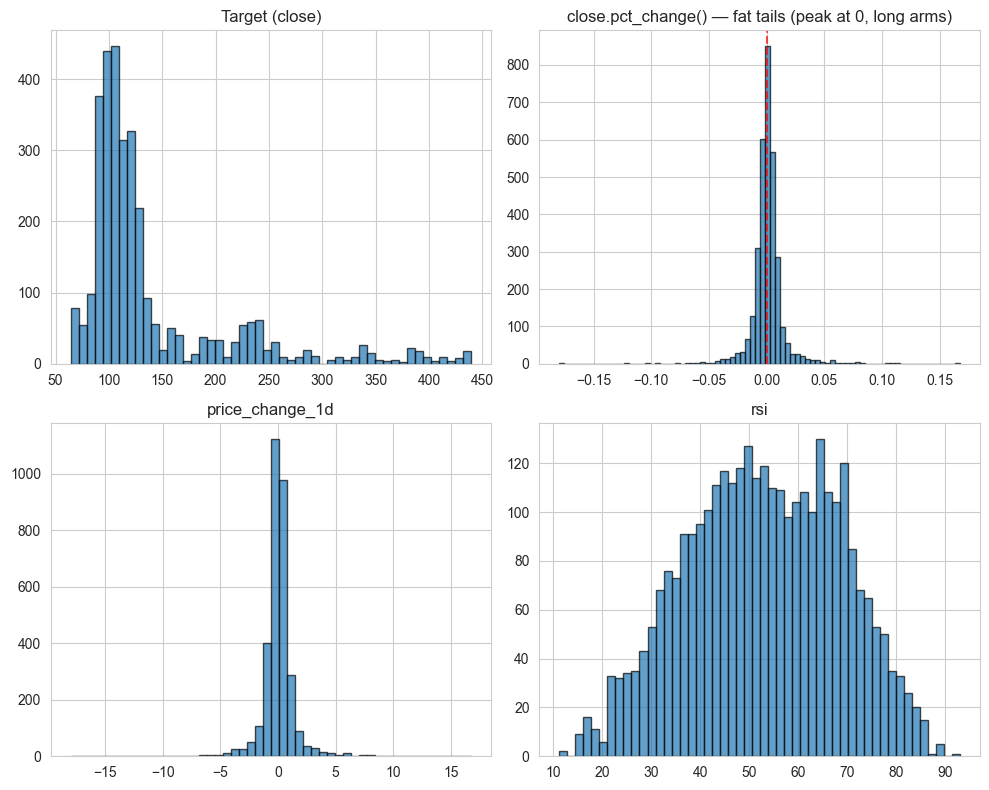

In [15]:
# Histograms: close (target), returns (fat tails), and anchors
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
df_features["close"].hist(ax=axes[0, 0], bins=50, edgecolor="black", alpha=0.7)
axes[0, 0].set_title("Target (close)")
returns = df_features["close"].pct_change().dropna()
returns.hist(ax=axes[0, 1], bins=80, edgecolor="black", alpha=0.7)
axes[0, 1].set_title("close.pct_change() — fat tails (peak at 0, long arms)")
axes[0, 1].axvline(0, color="red", linestyle="--", alpha=0.7)
if "price_change_1d" in df_features.columns:
    df_features["price_change_1d"].hist(ax=axes[1, 0], bins=50, edgecolor="black", alpha=0.7)
    axes[1, 0].set_title("price_change_1d")
if "rsi" in df_features.columns:
    df_features["rsi"].hist(ax=axes[1, 1], bins=50, edgecolor="black", alpha=0.7)
    axes[1, 1].set_title("rsi")
plt.tight_layout()
plt.show()

### Correlation & Multicollinearity

**Feature bloat harms training:** Multicollinearity (>0.98) causes gradient instability, overfitting (model predicts close from ema_12 instead of market logic), and VRAM/compute waste (26 features when 6–8 are unique).

**Pruning strategy:** Remove absolute price proxies (sma, ema, bb_upper/middle/lower); replace with **distance_to_sma200** and **ema_gap**. Remove twins (current_volume, rsi_14, williams_r). Keep derivatives: macd_histogram (rate-of-change; macd_line/signal removed), rsi, bb_width (volatility), bb_position (where in range), volatility_20, price changes.

**Distance-to-SMA rationale:** distance_to_sma200 tells the model if price is overextended or undervalued relative to its 200-bar trend—important for MU's cyclical/regime behavior, and lower correlation to raw close than feeding sma_200 directly.

**ema_gap rationale:** ema_12/ema_26 captures MACD-like momentum in ratio form; lower correlation to raw price than feeding ema_12 or ema_26 directly.

**BEFORE vs AFTER heatmaps** below show correlation before and after pruning.

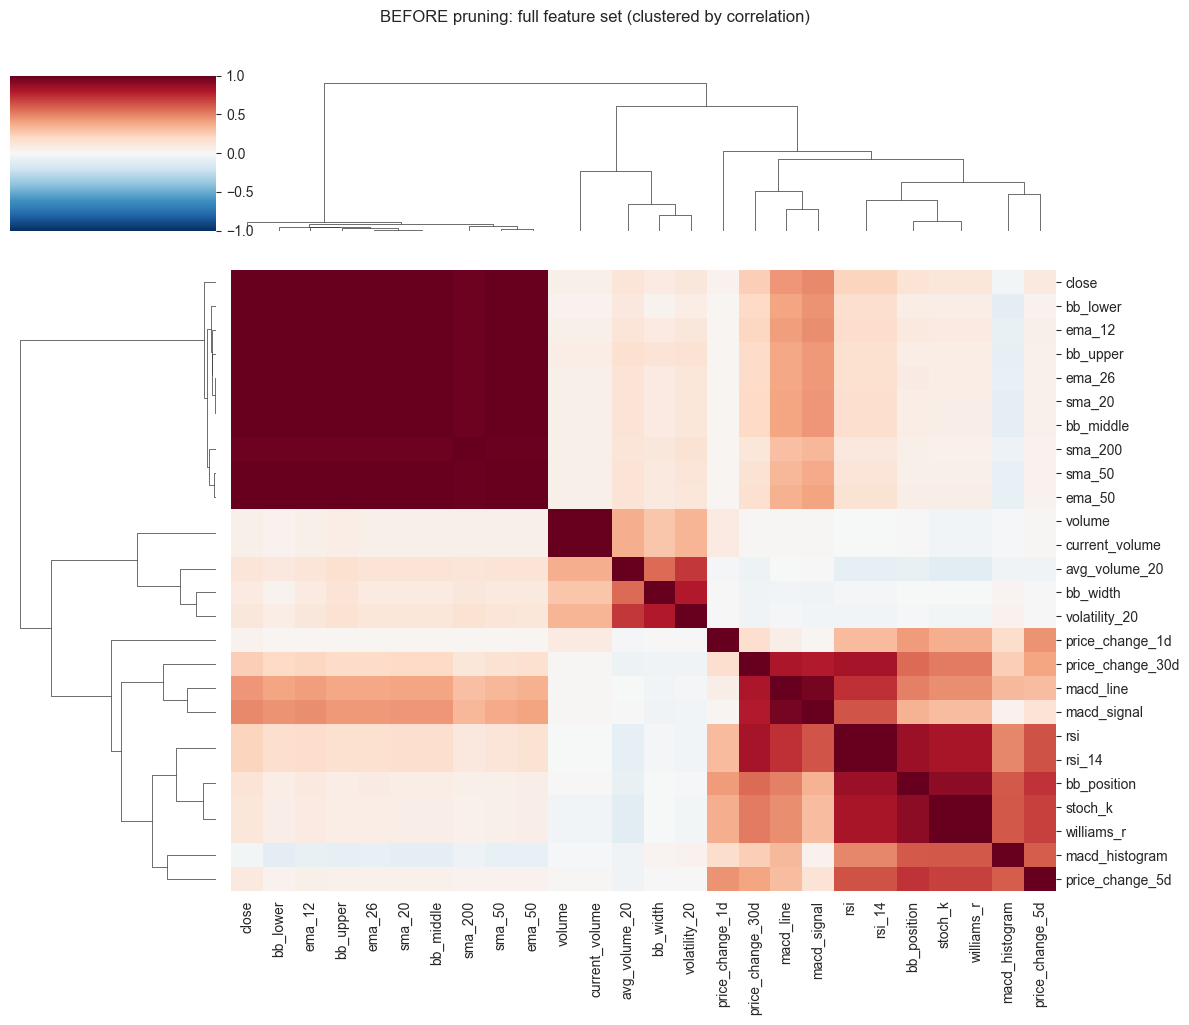

In [16]:
# BEFORE pruning: full feature set (feature bloat)
tvar_full = [
    "close", "volume",
    "sma_20", "sma_50", "sma_200", "ema_12", "ema_26", "ema_50",
    "rsi", "rsi_14", "macd_line", "macd_signal", "macd_histogram",
    "bb_upper", "bb_middle", "bb_lower", "bb_position", "bb_width",
    "stoch_k", "williams_r",
    "volatility_20", "price_change_1d", "price_change_5d", "price_change_30d",
    "avg_volume_20", "current_volume",
]
tvar_full = [c for c in tvar_full if c in df_features.columns]
corr_before = df_features[tvar_full].corr()
# Best practice: clustermap orders variables by hierarchical clustering (similar vars grouped)
g = sns.clustermap(corr_before, cmap="RdBu_r", center=0, vmin=-1, vmax=1, figsize=(12, 10),
                   row_cluster=True, col_cluster=True, annot=False)
g.fig.suptitle("BEFORE pruning: full feature set (clustered by correlation)", y=1.02)
plt.xticks(rotation=45, ha="right")
g.fig.tight_layout()
plt.show()
high = []
for i in range(len(corr_before.columns)):
    for j in range(i + 1, len(corr_before.columns)):
        c = corr_before.iloc[i, j]
        if abs(c) > 0.98:
            high.append((corr_before.columns[i], corr_before.columns[j], float(c)))


In [17]:
print(f"High-correlation pairs (> 0.98): {len(high)}")

High-correlation pairs (> 0.98): 45


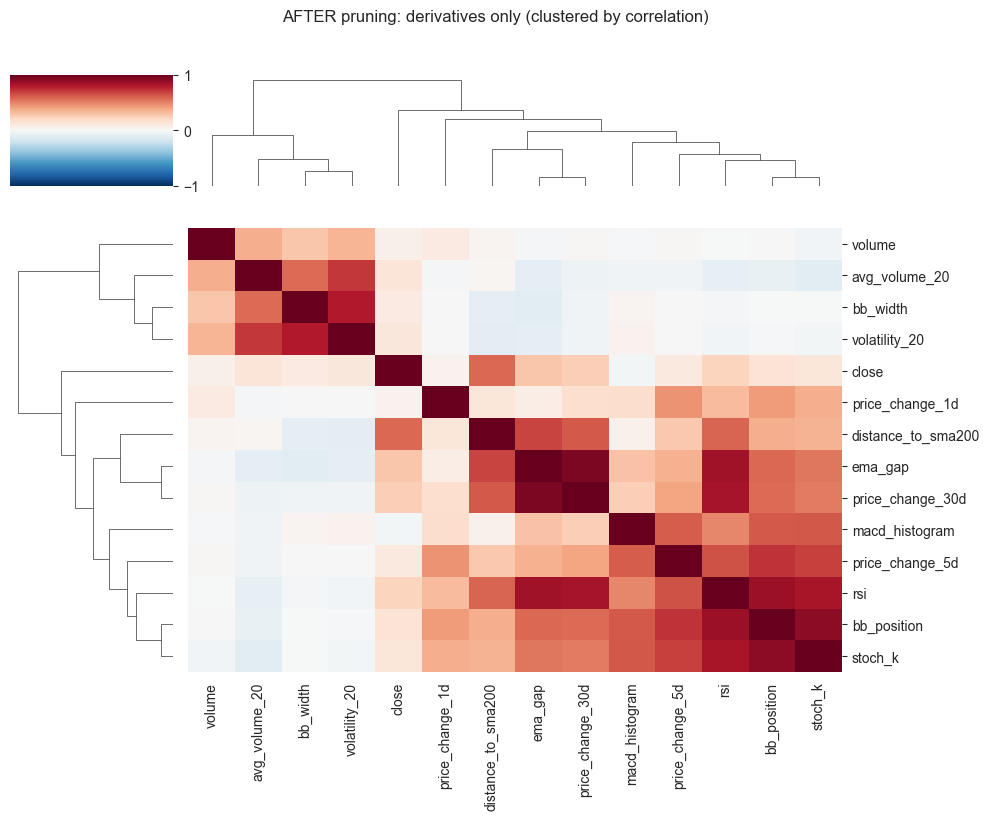

After pruning: no pairs with correlation > 0.98.


In [18]:
# Pruned feature set: close + derivatives (velocity, oscillation, volatility)
# Removed: absolute price proxies (sma_20, sma_50, sma_200, ema_12, ema_26, ema_50, bb_upper, bb_middle, bb_lower)
# Replaced with: distance_to_sma200, ema_gap. Removed twins: current_volume, rsi_14, williams_r.
PRUNED_FEATURES = [
    "close", "volume",
    "distance_to_sma200", "ema_gap",
    "macd_histogram", "rsi", "bb_position", "bb_width",
    "stoch_k",
    "volatility_20", "price_change_1d", "price_change_5d", "price_change_30d",
    "avg_volume_20",
]
pruned_cols = [c for c in PRUNED_FEATURES if c in df_features.columns]
corr_after = df_features[pruned_cols].corr()
# Best practice: clustermap orders variables by hierarchical clustering (similar vars grouped)
g = sns.clustermap(corr_after, cmap="RdBu_r", center=0, vmin=-1, vmax=1, figsize=(10, 8),
                   row_cluster=True, col_cluster=True, annot=False)
g.fig.suptitle("AFTER pruning: derivatives only (clustered by correlation)", y=1.02)
plt.xticks(rotation=45, ha="right")
g.fig.tight_layout()
plt.show()
high_after = [(corr_after.columns[i], corr_after.columns[j], float(corr_after.iloc[i, j]))
              for i in range(len(corr_after.columns)) for j in range(i + 1, len(corr_after.columns))
              if abs(corr_after.iloc[i, j]) > 0.98]
if high_after:
    print(f"After pruning: {len(high_after)} pairs with correlation > 0.98")
else:
    print("After pruning: no pairs with correlation > 0.98.")

In [19]:
# Print is in the cell above; re-run that cell to refresh high_after count.

# Normalization

*encoder-only, no look-ahead bias*

Use **TimeSeriesDataSet** with **EncoderNormalizer**: scaling is fit on each encoder sequence only, so no future information leaks into the past (no look-ahead bias).

**Robust scaling (median + IQR):** We use **method="robust"** instead of mean/std. Outliers (e.g. Black Swan events, flash crashes) are **not deleted**—they stay in the data so the model can learn from them—but robust scaling prevents extreme spikes from squishing the rest of the values into a tiny range. Applied after technical indicators, before the model.

**Indicator scaling rationale:**
- **Bounded indicators** (RSI 0-100, bb_position 0-1, stoch_k 0-100): Fixed range → identity scaling; avoids distorting their meaning.
- **Unbounded indicators** (close, volume, distance_to_sma200, ema_gap, macd_histogram, volatility, price changes): **EncoderNormalizer(method="robust")** (encoder-only, median/IQR).

### Data pipeline (how everything connects)

All later steps (e.g. **Temporal Fusion Transformer**) use the same data chain:

| Step | Variable | Description |
|------|----------|-------------|
| 1 | `df_market` | Adjusted OHLCV from DB or Yahoo (one symbol) |
| 2 | `df_features` | OHLCV + technical indicators, nulls dropped |
| 3 | `df_ts` | Same as `df_features` + `time_idx` + `ticker` (required by TimeSeriesDataSet) |
| 4 | `dataset` | TimeSeriesDataSet built from `df_ts` (encoder-only scaling, no look-ahead) |
| 5 | `dataloader` | `dataset.to_dataloader(...)` → batches for training |

**TFT and any other model in this notebook will use `dataset` and `dataloader` from above.**

In [20]:
# Prepare dataframe for TimeSeriesDataSet: need time_idx and group_ids
# time_idx = continuous integers (0,1,2,...), one per row; do NOT use raw timestamps (gaps break scaling).
# Assuming df_ts is sorted by time and contains only trading hours.
df_ts = df_features.copy()
df_ts["time_idx"] = np.arange(len(df_ts))
df_ts["ticker"] = SYMBOL  # single series → one group
# Pro-tip: hour (0-23) tells model to expect higher volatility/volume at market open (MU opening cross).
# 10 AM bar can be 5x more volatile than 1 PM; hour is a known covariate so model learns this pattern.
df_ts["hour"] = pd.to_datetime(df_ts["timestamp"], utc=True).dt.hour

# Time-varying features (unknown in the future). Bounded ones stay in list but get identity scaling.
# Close-focused: we predict close; open/high/low not fed as inputs to avoid redundancy and multicollinearity.
# bb_position (where in range) and bb_width (volatility) kept; bb_upper/middle/lower removed (too correlated with close).
# high/low still used inside compute_technical_indicators for stoch_k, williams_r.
# Pruned feature set: derivatives only (avoid gradient instability, overfitting, VRAM waste).
# Replaced absolute price proxies with: distance_to_sma200, ema_gap. See BEFORE/AFTER heatmaps.
time_varying_unknown_reals = [
    "close", "volume",
    "distance_to_sma200", "ema_gap",
    "macd_histogram", "rsi", "bb_position", "bb_width",
    "stoch_k",
    "volatility_20", "price_change_1d", "price_change_5d", "price_change_30d",
    "avg_volume_20",
]
time_varying_unknown_reals = [c for c in time_varying_unknown_reals if c in df_ts.columns]

# Bounded: fixed scale (0–100, 0–1, -100–0) → no scaling (identity). Unbounded → EncoderNormalizer.
BOUNDED_INDICATORS = ["rsi", "bb_position", "stoch_k"]
MIN_ENCODER_LENGTH = 60
MAX_ENCODER_LENGTH = 60
MIN_PREDICTION_LENGTH = 5
MAX_PREDICTION_LENGTH = 5

# Target has its own normalizer; do not put target in scalers (library requirement)
scaler_cols = [c for c in time_varying_unknown_reals if c != "close"]
# Robust scaling (median/IQR): keeps outliers in data, prevents extremes from squishing the rest
scalers = {
    col: (None if col in BOUNDED_INDICATORS else EncoderNormalizer(method="robust", center=True))
    for col in scaler_cols
}

# Show which attributes get normalization and which do not (target "close" uses target_normalizer)
normalized_attrs = [c for c in scaler_cols if scalers[c] is not None]
identity_attrs = [c for c in scaler_cols if scalers[c] is None]
norm_summary = pd.DataFrame({
    "attribute": normalized_attrs + identity_attrs + ["close"],
    "normalization": ["EncoderNormalizer (robust, encoder-only)"] * len(normalized_attrs)
    + ["None (identity)"] * len(identity_attrs)
    + ["EncoderNormalizer (robust, target_normalizer)"],
    "reason": ["Unbounded; robust scale (median/IQR); outliers retained"] * len(normalized_attrs)
    + ["Bounded (fixed range)"] * len(identity_attrs)
    + ["Target; robust encoder-only scale"],
})
display(norm_summary)



,attribute,normalization,reason
0,volume,"EncoderNormalizer (robust, encoder-only)",Unbounded; robust scale (median/IQR); outliers...
1,distance_to_sma200,"EncoderNormalizer (robust, encoder-only)",Unbounded; robust scale (median/IQR); outliers...
2,ema_gap,"EncoderNormalizer (robust, encoder-only)",Unbounded; robust scale (median/IQR); outliers...
3,macd_histogram,"EncoderNormalizer (robust, encoder-only)",Unbounded; robust scale (median/IQR); outliers...
4,bb_width,"EncoderNormalizer (robust, encoder-only)",Unbounded; robust scale (median/IQR); outliers...
5,volatility_20,"EncoderNormalizer (robust, encoder-only)",Unbounded; robust scale (median/IQR); outliers...
6,price_change_1d,"EncoderNormalizer (robust, encoder-only)",Unbounded; robust scale (median/IQR); outliers...
7,price_change_5d,"EncoderNormalizer (robust, encoder-only)",Unbounded; robust scale (median/IQR); outliers...
8,price_change_30d,"EncoderNormalizer (robust, encoder-only)",Unbounded; robust scale (median/IQR); outliers...
9,avg_volume_20,"EncoderNormalizer (robust, encoder-only)",Unbounded; robust scale (median/IQR); outliers...


### PyTorch Forecasting: time_idx must be continuous

**The gap problem:** With hourly data, the market is only open ~7 hours per day (e.g. 9:30 AM – 4:00 PM EST). Raw timestamps therefore have large gaps (overnight, weekends). If you use timestamps or a time-of-day index as `time_idx`, the EncoderNormalizer and model see a huge "jump" between Friday close and Monday open, which can distort scaling and learning.

**The solution:** Do **not** use raw timestamps as `time_idx`. Use a **continuous integer index** (0, 1, 2, …) that counts only active trading bars. Each row = one bar; `time_idx` increments by 1 for every row. This keeps the sequence continuous and avoids artificial gaps.

In [21]:
# EncoderNormalizer: fit scale on each encoder sequence only → no look-ahead bias
dataset = TimeSeriesDataSet(
    df_ts,
    time_idx="time_idx",
    target="close",
    group_ids=["ticker"],
    min_encoder_length=MIN_ENCODER_LENGTH,
    max_encoder_length=MAX_ENCODER_LENGTH,
    min_prediction_length=MIN_PREDICTION_LENGTH,
    max_prediction_length=MAX_PREDICTION_LENGTH,
    time_varying_known_reals=["hour"],  # expects higher volatility/volume at market open (0–23)
    time_varying_unknown_reals=time_varying_unknown_reals,
    target_normalizer=EncoderNormalizer(method="robust", center=True),
    scalers=scalers,
)

dataloader = dataset.to_dataloader(train=True, batch_size=32, num_workers=0)
print(f"TimeSeriesDataSet: {len(dataset)} samples, encoder={MAX_ENCODER_LENGTH}, prediction={MAX_PREDICTION_LENGTH}")
batch = next(iter(dataloader))
print(f"Batch keys: {list(batch[0].keys())}")

TimeSeriesDataSet: 3171 samples, encoder=60, prediction=5
Batch keys: ['encoder_cat', 'encoder_cont', 'encoder_target', 'encoder_lengths', 'decoder_cat', 'decoder_cont', 'decoder_target', 'decoder_lengths', 'decoder_time_idx', 'groups', 'target_scale']


In [22]:
# Verify link: prev data → TFT-ready dataset (run this to confirm the pipeline)
assert "time_idx" in df_ts.columns and "ticker" in df_ts.columns
assert len(df_ts) == len(df_features), "df_ts = df_features + time_idx + ticker"
assert set(df_features.columns).issubset(df_ts.columns), "df_ts contains all df_features columns"

In [23]:
pipeline = {
    "df_market": (len(df_market), list(df_market.columns)),
    "df_features": (len(df_features), list(df_features.columns)),
    "df_ts": (len(df_ts), list(df_ts.columns)),
    "dataset (TimeSeriesDataSet)": (len(dataset), "encoder/decoder batches"),
    "dataloader": (len(dataloader), "batch_size=32"),
}

In [24]:
print("Data pipeline (prev → new dataset):")

for name, (size, detail) in pipeline.items():
    print(f"{name}: n={size}  ({detail})")
    print(f"\n")
print("\n→ Use 'dataset' and 'dataloader' for TFT (or any PyTorch Forecasting model).")

Data pipeline (prev → new dataset):
df_market: n=3434  (['timestamp', 'open', 'high', 'low', 'close', 'volume'])


df_features: n=3235  (['timestamp', 'open', 'high', 'low', 'close', 'volume', 'sma_20', 'sma_50', 'sma_200', 'ema_12', 'ema_26', 'ema_50', 'rsi', 'rsi_14', 'macd_line', 'macd_signal', 'macd_histogram', 'bb_middle', 'bb_upper', 'bb_lower', 'bb_position', 'bb_width', 'stoch_k', 'williams_r', 'distance_to_sma200', 'ema_gap', 'volatility_20', 'price_change_1d', 'price_change_5d', 'price_change_30d', 'avg_volume_20', 'current_volume'])


df_ts: n=3235  (['timestamp', 'open', 'high', 'low', 'close', 'volume', 'sma_20', 'sma_50', 'sma_200', 'ema_12', 'ema_26', 'ema_50', 'rsi', 'rsi_14', 'macd_line', 'macd_signal', 'macd_histogram', 'bb_middle', 'bb_upper', 'bb_lower', 'bb_position', 'bb_width', 'stoch_k', 'williams_r', 'distance_to_sma200', 'ema_gap', 'volatility_20', 'price_change_1d', 'price_change_5d', 'price_change_30d', 'avg_volume_20', 'current_volume', 'time_idx', 'ticker'

# Temporal Fusion Transformer (TFT)

MU is a **macro stock** that behaves like a **micro stock** around earnings—sensitive to both long-term semiconductor cycles and sudden intraday news. The TFT is built for this dual nature:

1. **Variable Selection Networks (VSN)**  
   Assigns weights to each input (RSI, MACD, volume, etc.) at each time step. In a *quiet regime* the VSN may prioritize `distance_to_sma200`; in a *volatile regime* (e.g. post-earnings) it can shift attention to hourly volume and `price_change_1d`, effectively ignoring less relevant long-term averages.

2. **Multi-head attention**  
   Captures long-range dependencies (e.g. compare 10:00 AM open three days ago to today’s 10:00 AM) without recency bias. Attention is highly parallelizable on GPU—efficient on RTX 3050.

3. **Interpretable multi-horizon + quantiles**  
   TFT outputs quantiles (e.g. 10th, 50th, 90th), not just a point forecast. The spread (e.g. 90th vs 10th) widens in high-uncertainty periods (e.g. hour before 4 PM close), which is useful for risk and position sizing.

**RTX 3050–friendly defaults (4–6 GB VRAM):**

| Parameter | Recommended | Reason |
|-----------|-------------|--------|
| `hidden_size` | 32 or 64 | Fits VRAM; enough for MU’s complexity |
| `attention_head_size` | 4 | Track several market “modes” |
| `dropout` | 0.1–0.2 | Reduce overfitting on noisy bars |
| `loss` | QuantileLoss() | Predict ranges; supports risk view |

### Training strategy

- **Loss:** Quantile Loss (fat tails, risk ranges). A hybrid with RMSE would penalize large outliers, but TFT requires a loss with `rescale_parameters`; `CompositeMetric` does not implement it, so we use QuantileLoss only. Avoid MAE/MAPE—MAPE over-penalizes when price is low.
- **Validation = last 3 months:** Use Nov 2025 – Jan 2026 (or last 90 days of data) so the model prioritizes recent, higher-volatility patterns over "stable 2025" growth and avoids regime overfit.
- **Backtesting:** Out-of-sample test should include at least one earnings window; walk-forward (expand train, roll test) is preferred over a single 70/30 split.
- **Training:** `gradient_clip_val=0.1` (stops one bad hour from poisoning weights), `precision="32"` to avoid float16 overflow; optional `bf16-mixed` for speed.

In [25]:
# TFT helpers: single place for dataset, model, and trainer (used by main training and walk-forward)
def make_tft_dataset(df_train):
    """Build TimeSeriesDataSet from training dataframe. Uses globals: time_varying_unknown_reals, scalers, MIN/MAX_*."""
    return TimeSeriesDataSet(
        df_train,
        time_idx="time_idx",
        target="close",
        group_ids=["ticker"],
        min_encoder_length=MIN_ENCODER_LENGTH,
        max_encoder_length=MAX_ENCODER_LENGTH,
        min_prediction_length=MIN_PREDICTION_LENGTH,
        max_prediction_length=MAX_PREDICTION_LENGTH,
        time_varying_known_reals=["hour"],
        time_varying_unknown_reals=time_varying_unknown_reals,
        target_normalizer=EncoderNormalizer(method="robust", center=True),
        scalers=scalers,
    )

def make_tft_model(dataset):
    """Build TFT from dataset (RTX 3050–friendly defaults, QuantileLoss)."""
    return TemporalFusionTransformer.from_dataset(
        dataset,
        learning_rate=1e-3,
        hidden_size=32,
        attention_head_size=4,
        dropout=0.15,
        loss=QuantileLoss(),
    )

def make_tft_trainer(max_epochs=100, patience=5):
    """Build Lightning Trainer with gradient clip and early stopping."""
    return pl.Trainer(
        max_epochs=max_epochs,
        accelerator="auto",
        gradient_clip_val=0.1,
        precision="32",
        callbacks=[
            EarlyStopping(monitor="val_loss", patience=patience, mode="min"),
            LearningRateMonitor(logging_interval="epoch"),
        ],
    )

In [26]:
# TFT: 2026 Pro — validation = last 3 months (run "TFT helpers" cell first)
ts = pd.to_datetime(df_ts["timestamp"], utc=True)
cutoff = ts.max() - pd.Timedelta(days=90)
min_val_idx = int(df_ts.loc[ts >= cutoff, "time_idx"].min())
df_train = df_ts[df_ts["time_idx"] < min_val_idx]

train_dataset = make_tft_dataset(df_train)
validation = TimeSeriesDataSet.from_dataset(train_dataset, df_ts, min_prediction_idx=min_val_idx)
train_dl = train_dataset.to_dataloader(train=True, batch_size=32, num_workers=0)
val_dl = validation.to_dataloader(train=False, batch_size=32, num_workers=0)

tft = make_tft_model(train_dataset)
trainer = make_tft_trainer(max_epochs=100, patience=5)
trainer.fit(tft, train_dataloaders=train_dl, val_dataloaders=val_dl)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃    ┃ Name                               ┃ Type                            ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0  │ loss                               │ QuantileLoss                    │      0 │ train │     0 │
│ 1  │ logging_metrics                    │ ModuleList                      │      0 │ train │     0 │
│ 2  │ input_embeddings                   │ MultiEmbedding                  │      0 │ train │     0 │
│ 3  │ prescalers                         │ ModuleDict                      │    240 │ train │     0 │
│ 4  │ static_variable_selection          │ VariableSelectionNetwork        │      0 │ train │     0 │
│ 5  │ encoder_variable_selection         │ VariableSelectionNetwork        │ 16.5 K │ train │     0 │
│ 6  │ decoder_variable_selection         │ VariableSelectionNetwork        │    896 │ train │     0 │
│ 7  │ static_context_variable_selection  │ GatedResidualNetwork            │  4.3 K │ train │     0 │
│ 8  │ static_context_initial_hidden_lstm │ GatedResidualNetwork            │  4.3 K │ train │     0 │
│ 9  │ static_context_initial_cell_lstm   │ GatedResidualNetwork            │  4.3 K │ train │     0 │
│ 10 │ static_context_enrichment          │ GatedResidualNetwork            │  4.3 K │ train │     0 │
│ 11 │ lstm_encoder                       │ LSTM                            │  8.4 K │ train │     0 │
│ 12 │ lstm_decoder                       │ LSTM                            │  8.4 K │ train │     0 │
│ 13 │ post_lstm_gate_encoder             │ GatedLinearUnit                 │  2.1 K │ train │     0 │
│ 14 │ post_lstm_add_norm_encoder         │ AddNorm                         │     64 │ train │     0 │
│ 15 │ static_enrichment                  │ GatedResidualNetwork            │  5.3 K │ train │     0 │
│ 16 │ multihead_attn                     │ InterpretableMultiHeadAttention │  2.6 K │ train │     0 │
│ 17 │ post_attn_gate_norm                │ GateAddNorm                     │  2.2 K │ train │     0 │
│ 18 │ pos_wise_ff                        │ GatedResidualNetwork            │  4.3 K │ train │     0 │
│ 19 │ pre_output_gate_norm               │ GateAddNorm                     │  2.2 K │ train │     0 │
│ 20 │ output_layer                       │ Linear                          │    231 │ train │     0 │
└────┴────────────────────────────────────┴─────────────────────────────────┴────────┴───────┴───────┘

Trainable params: 70.4 K                                                                                           
Non-trainable params: 0                                                                                            
Total params: 70.4 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 371                                                                                         
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

In [27]:
# Optional: Variable importance (VSN) — which inputs the TFT prioritizes
# interpret_output() expects the *model output* (dict), not the dataloader batch (tuple).
try:
    batch = next(iter(val_dl))
    x = batch[0] if isinstance(batch, (tuple, list)) else batch
    with torch.no_grad():
        out = tft(x)
    # Some versions return a named tuple; interpret_output needs a dict.
    out_dict = out._asdict() if hasattr(out, "_asdict") else out
    interpretation = tft.interpret_output(out_dict, reduction="sum")
    # interpretation is a dict: encoder_variables, decoder_variables, static_variables, attention
    enc = interpretation.get("encoder_variables", getattr(interpretation, "encoder_variables", None))
    if enc is not None:
        enc_1d = enc.flatten().cpu().tolist()
        names = getattr(tft, "encoder_variables", None)
        if names is not None and len(names) == len(enc_1d):
            imp = dict(zip(names, enc_1d))
        else:
            imp = enc_1d
        print("Encoder variable importance (VSN):", imp)
except Exception as e:
    print("Interpretation error:", e)

Encoder variable importance (VSN): {'hour': 0.1989869773387909, 'close': 25.740615844726562, 'volume': 0.4537537693977356, 'distance_to_sma200': 0.2163347601890564, 'ema_gap': 0.4709152579307556, 'macd_histogram': 0.5117934942245483, 'rsi': 0.29786306619644165, 'bb_position': 0.6064628958702087, 'bb_width': 0.5716142654418945, 'stoch_k': 0.44045490026474, 'volatility_20': 0.4941730499267578, 'price_change_1d': 0.737525999546051, 'price_change_5d': 0.40157783031463623, 'price_change_30d': 0.30513760447502136, 'avg_volume_20': 0.5527875423431396}


### Attention map and variable importance

**Temporal Insight (Attention Maps):** The TFT's attention heads show which historical steps the model used. Use this to show stakeholders the model is "looking at" the right events—e.g. ignoring a holiday glitch and focusing on a recent catalyst (rate pivot, earnings). The heatmap below plots attention over encoder time (e.g. last 60 hours).

**How to read the attention plot (high-volatility regime):**
- **Recency spikes:** High attention in the last 1–4 hours → model reacting to intraday micro-patterns.
- **Cyclical peaks:** Bumps every ~7 hours (trading day) or ~35 hours (week) → learned daily/weekly seasonality.
- **Gap focus:** After an earnings gap, attention can shift to the last hour before the gap as a baseline.

**Variable importance (VSN):** Expect **high** for `bb_width` and `volatility_20` in volatile periods; **medium** for `rsi`, `macd_histogram` (momentum); **low** for static (e.g. ticker) once the model has learned the stock.

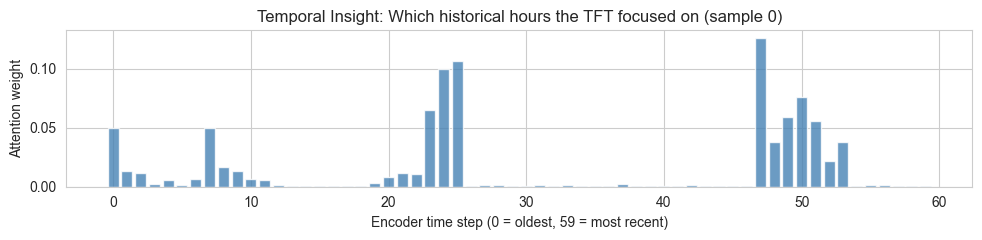

In [28]:
# Temporal Insight: Attention heatmap (which encoder steps the model focused on)
# Run after the attention/interpretation cell; uses one batch and extracts encoder_attention from TFT output.

batch = next(iter(val_dl))
x = batch[0] if isinstance(batch, (tuple, list)) else batch
with torch.no_grad():
    out = tft(x)
out_dict = out._asdict() if hasattr(out, "_asdict") else out
enc_attn = out_dict.get("encoder_attention")
if enc_attn is not None:
    # enc_attn: (batch, n_heads, dec_len, enc_len) or similar; take first sample, mean over heads and decoder
    a = enc_attn[0].cpu().float().numpy()
    if a.ndim == 3:
        a = a.mean(axis=(0, 1))
    elif a.ndim == 2:
        a = a.mean(axis=0)
    enc_len = len(a)
    fig, ax = plt.subplots(figsize=(10, 2.5))
    ax.bar(range(enc_len), a, color="steelblue", alpha=0.8)
    ax.set_xlabel("Encoder time step (0 = oldest, {} = most recent)".format(enc_len - 1))
    ax.set_ylabel("Attention weight")
    ax.set_title("Temporal Insight: Which historical hours the TFT focused on (sample 0)")
    plt.tight_layout()
    plt.show()
else:
    print("encoder_attention not in model output; check TFT version.")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


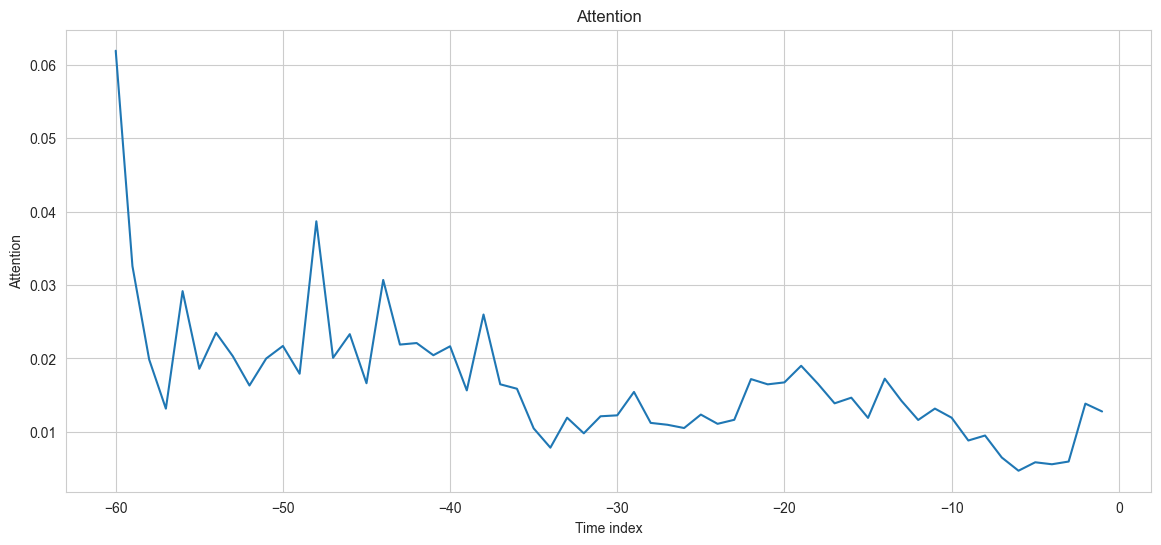

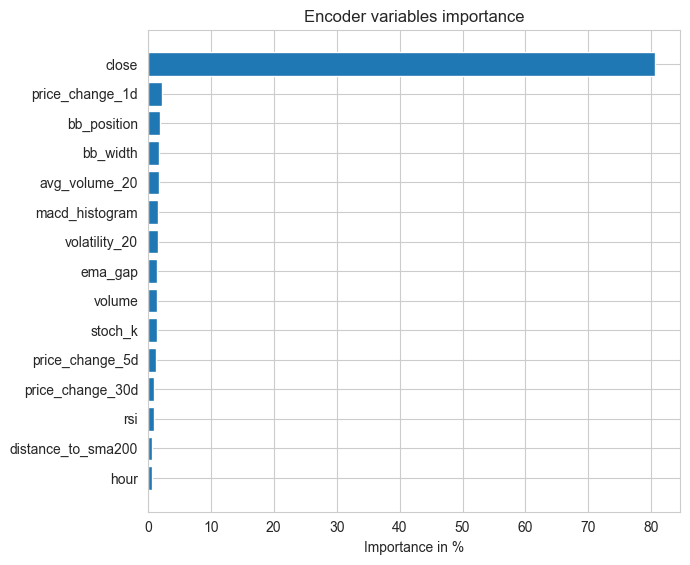

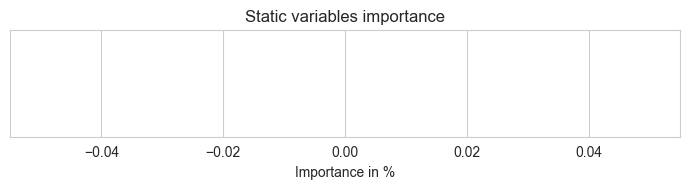

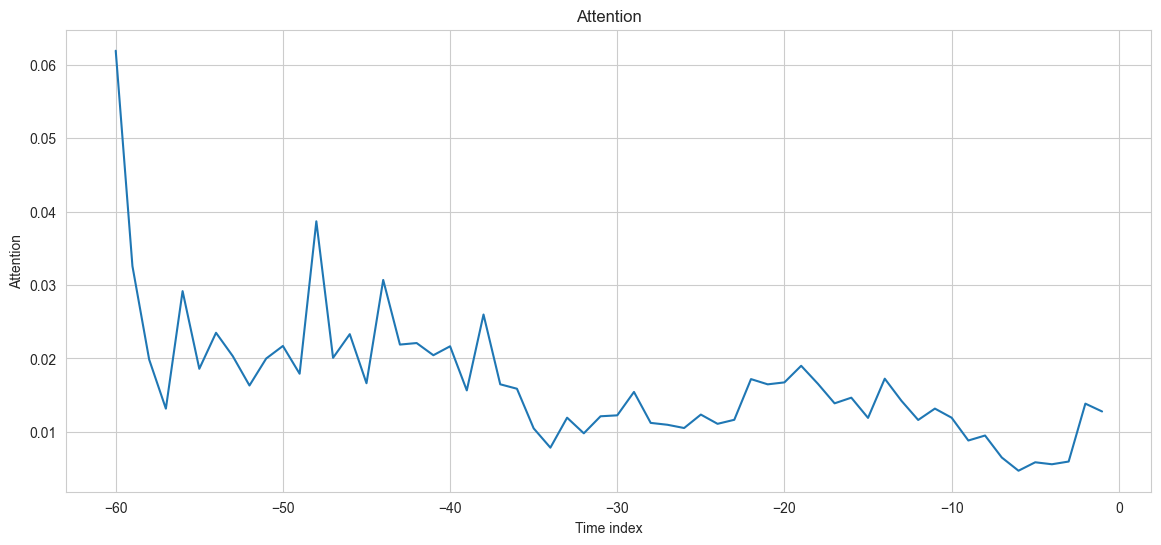

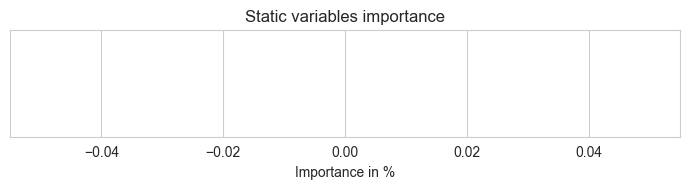

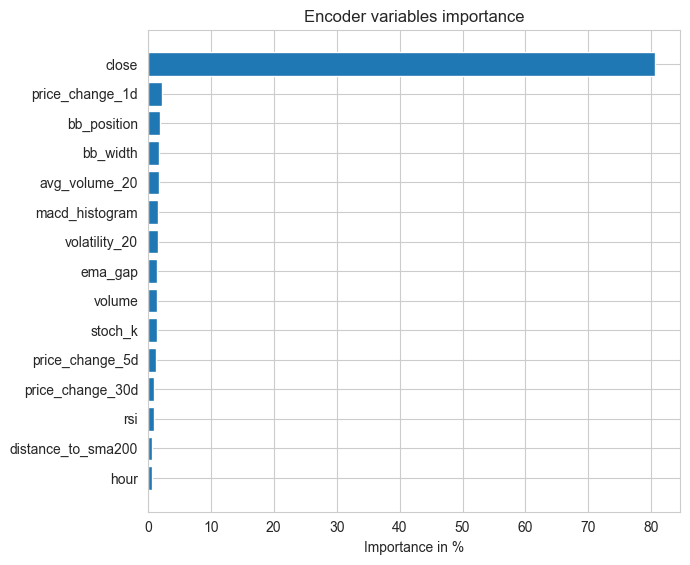

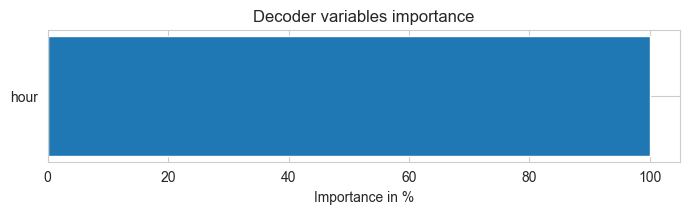

In [29]:
# Attention map and variable importance plots (run after TFT training and VSN cell)
# Uses validation dataloader; needs raw model output for attention/VSN weights.
import matplotlib.pyplot as plt

interpretation = None
try:
    # Prefer: predict with mode="raw" to get full output (attention + variable weights)
    raw_predictions = tft.predict(val_dl, mode="raw", return_x=True)
    out_for_interp = raw_predictions.output if hasattr(raw_predictions, "output") else raw_predictions
    if isinstance(out_for_interp, (list, tuple)):
        out_for_interp = out_for_interp[0]._asdict() if hasattr(out_for_interp[0], "_asdict") else out_for_interp[0]
    interpretation = tft.interpret_output(out_for_interp, reduction="sum")
except Exception:
    # Fallback: one batch forward pass, then interpret_output
    batch = next(iter(val_dl))
    x = batch[0] if isinstance(batch, (tuple, list)) else batch
    with torch.no_grad():
        out = tft(x)
    out_dict = out._asdict() if hasattr(out, "_asdict") else out
    interpretation = tft.interpret_output(out_dict, reduction="sum")

if interpretation is not None and hasattr(tft, "plot_interpretation"):
    figs = tft.plot_interpretation(interpretation)
    from IPython.display import display
    for name in ["attention", "encoder_variables", "static_variables"]:
        if figs.get(name) is not None:
            display(figs[name])
else:
    print("plot_interpretation not available or interpretation failed; see VSN cell for text importance.")

# XAI: SHAP as the "Flight Recorder"

SHAP gives a **model-agnostic** view of how each feature pushed the prediction up or down for a given hour. The TFT's VSN is model-internal; SHAP is the gold standard for "why did the model say that?"

- **Global logic:** Summary plot shows which features drive the model overall. In Feb 2026, expect **Volume** and **Volatility** to rank high vs 2025's momentum.
- **Direction:** Positive SHAP on high Volume → "volume confirms breakout"; negative → "exhaustion selling."
- **RTX 3050:** We use **KernelExplainer** with a small background (50–100 samples) to avoid memory issues. Encoder-only SHAP shows impact of normalized features (how much a local spike in volume mattered).

### Local Attribution (Integrated Gradients)

For a **specific prediction** (e.g. a "Sell" signal), Integrated Gradients traces the prediction back to a baseline and attributes contribution per input. Example: "70% of the bearish signal is due to a volatility spike, 10% due to price action." Uses **encoder_cont** only; baseline = zero (or mean). Requires `pip install captum`.

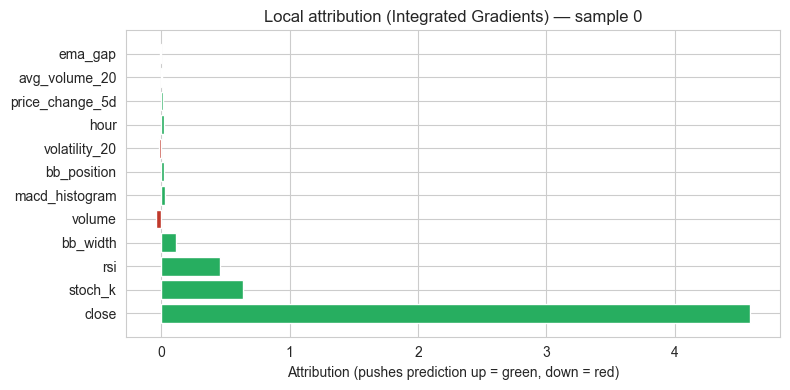

In [30]:
# Integrated Gradients: local attribution for one sample (e.g. "Sell" = lowest prediction)
# Run after TFT training; pip install captum


ref = next(iter(val_dl))[0]
enc = ref["encoder_cont"]
device = next(tft.parameters()).device
B, T, F = enc.shape
# Pick one sample: use first, or uncomment next line to pick "sell" (lowest prediction)
sample_idx = 0
# with torch.no_grad(): preds = tft.loss.to_prediction(tft(ref).prediction); sample_idx = preds.mean(dim=1).argmin().item()
input_enc = ref["encoder_cont"][sample_idx : sample_idx + 1].clone().detach().to(device).requires_grad_(True)
baseline_enc = torch.zeros_like(input_enc, device=device)

def forward_fn(encoder_cont):
    n = encoder_cont.shape[0]
    batch = {}
    for k, v in ref.items():
        if not isinstance(v, torch.Tensor):
            batch[k] = v
            continue
        b = v.shape[0]
        if b >= n:
            batch[k] = v[:n].to(device)
        else:
            mult = (n + b - 1) // b
            batch[k] = v.repeat(mult, *([1] * (v.dim() - 1)))[:n].to(device)
    batch["encoder_cont"] = encoder_cont
    out = tft(batch)
    pred = out.prediction if hasattr(out, "prediction") else out[0]
    point = tft.loss.to_prediction(pred).mean(dim=1)
    return point

ig = IntegratedGradients(forward_fn)
attr = ig.attribute(input_enc, baselines=baseline_enc)
attr = attr.detach().cpu().numpy().squeeze(0)
encoder_feature_names = getattr(tft, "encoder_variables", None)
if not encoder_feature_names or len(encoder_feature_names) != F:
    encoder_feature_names = [f"f{i}" for i in range(F)]
if encoder_feature_names and len(encoder_feature_names) == F:
    attr_per_feature = attr.sum(axis=0)
    fig, ax = plt.subplots(figsize=(8, 4))
    order = np.argsort(np.abs(attr_per_feature))[::-1][:12]
    ax.barh(range(len(order)), attr_per_feature[order], color=["#c0392b" if attr_per_feature[i] < 0 else "#27ae60" for i in order])
    ax.set_yticks(range(len(order)))
    ax.set_yticklabels([encoder_feature_names[i] for i in order])
    ax.set_xlabel("Attribution (pushes prediction up = green, down = red)")
    ax.set_title("Local attribution (Integrated Gradients) — sample {}".format(sample_idx))
    plt.tight_layout()
    plt.show()
else:
    print("Attribution shape:", attr.shape, "— sum over time for per-feature bar.")

In [31]:
# SHAP "Flight Recorder" — global feature importance (run after TFT training; pip install shap)
# Uses last encoder step only so SHAP explains "how does the most recent hour's features drive the forecast."


# Reference batch and encoder shape
ref = next(iter(val_dl))[0]
enc = ref["encoder_cont"]
device = next(tft.parameters()).device
B, T, F = enc.shape
# Last step only: (n, F) for SHAP
background = enc[: min(50, B), -1, :].cpu().numpy()
test_sample = enc[: min(10, B), -1, :].cpu().numpy()
encoder_feature_names = getattr(tft, "encoder_variables", None) or ["hour"] + [c for c in time_varying_unknown_reals if c != "close"]
if len(encoder_feature_names) != F:
    encoder_feature_names = [f"f{i}" for i in range(F)]

def predict_func(last_step_np):
    """Predict from last encoder step: inject into reference batch, return point forecast (n,)."""
    n = last_step_np.shape[0]
    enc_full = enc[:1].expand(n, T, F).clone().to(device)
    enc_full[:, -1, :] = torch.tensor(last_step_np, dtype=enc.dtype, device=device)
    batch = {}
    for k, v in ref.items():
        if not isinstance(v, torch.Tensor):
            batch[k] = v
            continue
        b = v.shape[0]
        if b >= n:
            batch[k] = v[:n].to(device)
        else:
            mult = (n + b - 1) // b
            batch[k] = v.repeat(mult, *([1] * (v.dim() - 1)))[:n].to(device)
    batch["encoder_cont"] = enc_full
    with torch.no_grad():
        out = tft(batch)
    pred = out.prediction if hasattr(out, "prediction") else out[0]
    point = tft.loss.to_prediction(pred).cpu().numpy()
    return point.mean(axis=1)

explainer = shap.KernelExplainer(predict_func, background)
shap_values = explainer.shap_values(test_sample, nsamples=50)

  0%|          | 0/10 [00:00<?, ?it/s]

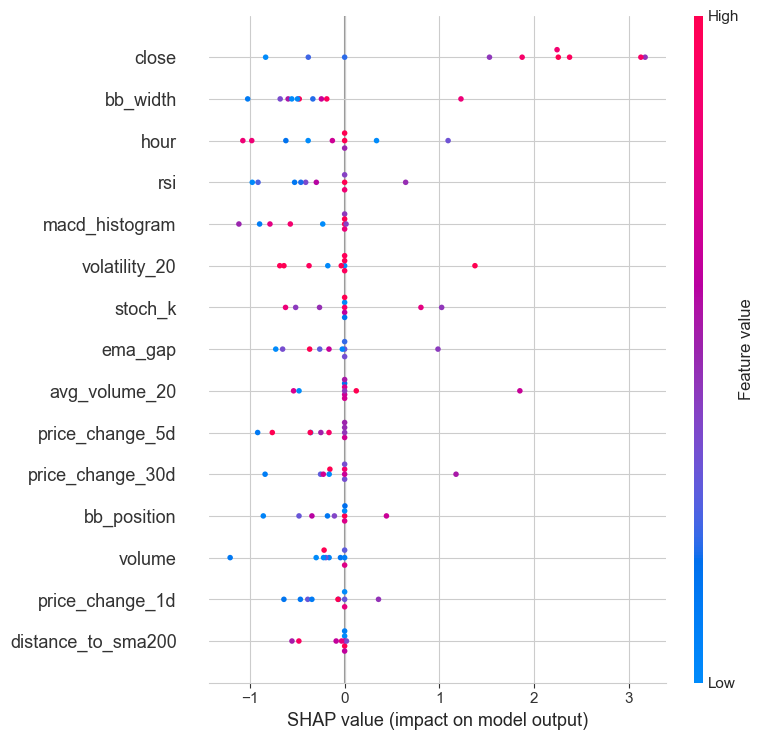

In [32]:
shap.summary_plot(shap_values, test_sample, feature_names=encoder_feature_names)

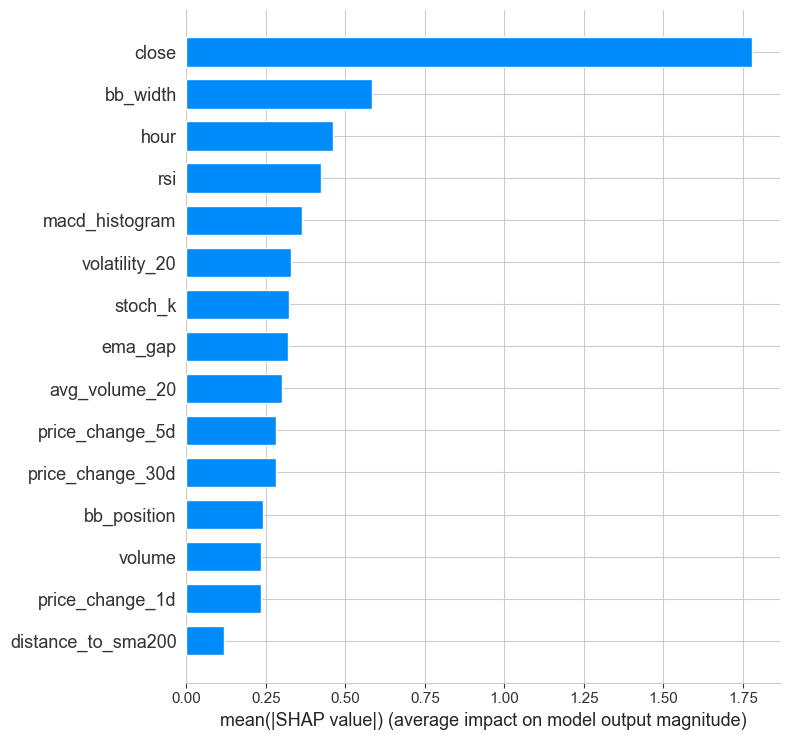

In [33]:
# Bar: mean |SHAP| per feature (global importance ranking)
plt.figure()
shap.summary_plot(shap_values, test_sample, feature_names=encoder_feature_names, plot_type="bar", show=False)
plt.tight_layout()
plt.show()

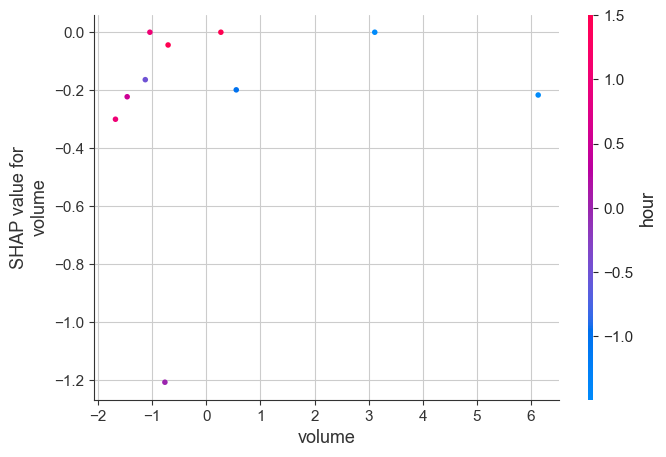

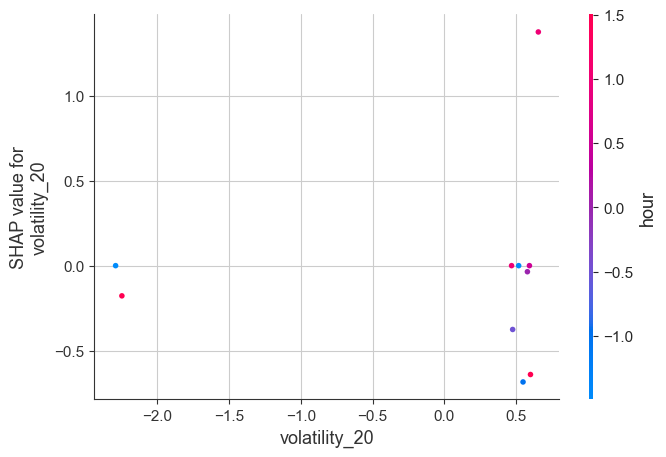

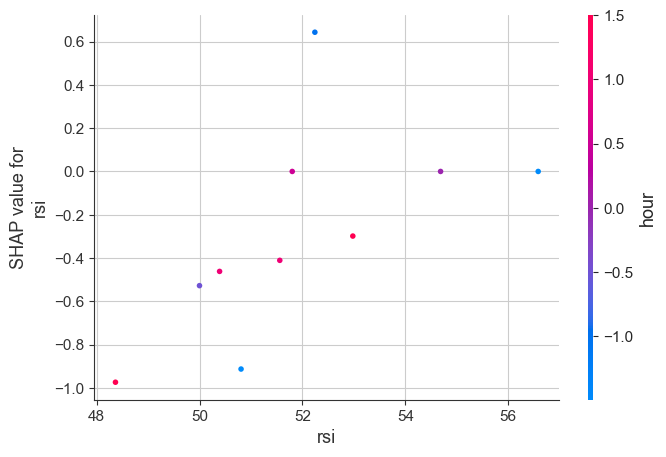

In [34]:
# Dependence: how one feature's value relates to its SHAP (relationship + interaction)
for feat in ["volume", "volatility_20", "rsi"]:
    if feat in encoder_feature_names:
        idx = encoder_feature_names.index(feat)
        shap.dependence_plot(idx, shap_values, test_sample, feature_names=encoder_feature_names)

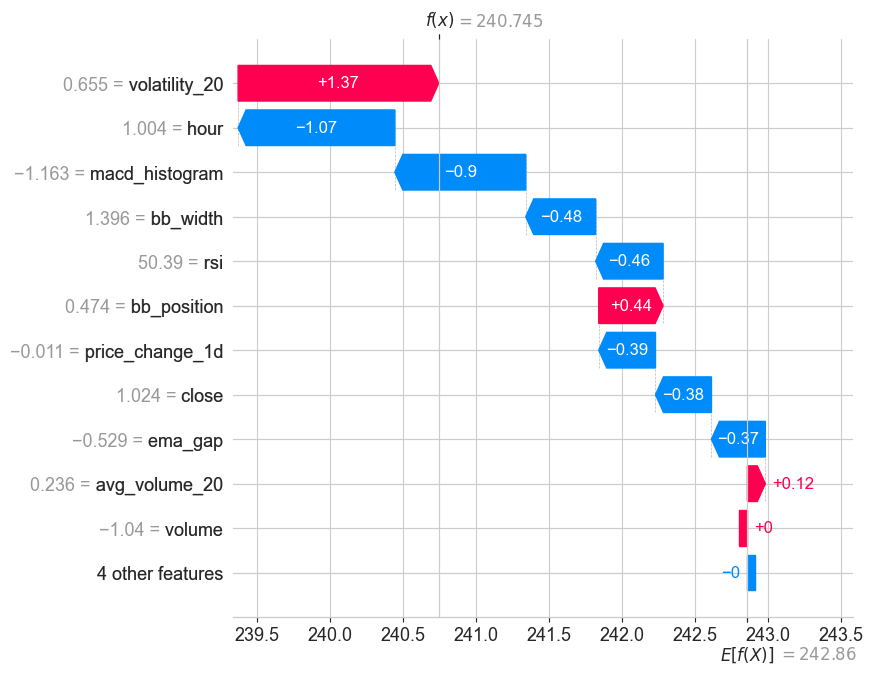

In [35]:
# Waterfall: one-sample breakdown (how each feature pushed prediction up/down)
base_val = float(np.asarray(explainer.expected_value).flat[0]) if hasattr(explainer, "expected_value") else 0.0
explanation = shap.Explanation(values=shap_values[0], base_values=base_val, data=test_sample[0], feature_names=encoder_feature_names)
shap.plots.waterfall(explanation, max_display=12)

# Walk-forward backtesting (optional)

Standard 70/30 splits fail when the regime changes (e.g. stable 2025 vs volatile Feb 2026). **Walk-forward:** expand training window and test on the next period (e.g. Train Jan 2024–June 2025 → Test July 2025; then Train to July 2025 → Test Aug 2025). For MU, ensure at least one out-of-sample window includes an **earnings announcement** so the model is validated on event volatility.

In [36]:
# Walk-forward testing: expand train window, test on next period, refit per fold
# Run after TFT helpers + main TFT cell (uses make_tft_*, df_ts, constants).

# --- Config ---
MIN_TRAIN_BARS = 2000          # minimum training length (e.g. ~1 year of hourly)
TEST_BARS = 154                # test window length (~1 month: 22 days * 7 hrs)
STEP_BARS = 154                # step between folds (non-overlapping months)
MAX_EPOCHS_PER_FOLD = 30      # cap epochs per fold to limit runtime
PATIENCE = 5

max_time = int(df_ts["time_idx"].max())
test_starts = range(MIN_TRAIN_BARS, max_time - TEST_BARS - MAX_PREDICTION_LENGTH + 1, STEP_BARS)
test_starts = list(test_starts)
if not test_starts:
    print("Not enough data for walk-forward: need max_time >= MIN_TRAIN_BARS + TEST_BARS + MAX_PREDICTION_LENGTH")
else:
    print(f"Walk-forward: {len(test_starts)} folds, test window = {TEST_BARS} bars (~1 month), step = {STEP_BARS}")

Walk-forward: 7 folds, test window = 154 bars (~1 month), step = 154


In [ ]:
# Per-fold: train TFT on data before test_start, evaluate on [test_start, test_start + TEST_BARS)
# Uses make_tft_dataset, make_tft_model, make_tft_trainer from "TFT helpers" cell.
results = []
for fold, test_start_idx in enumerate(test_starts):
    df_train_fold = df_ts[df_ts["time_idx"] < test_start_idx]
    ts_fold = pd.to_datetime(df_train_fold["timestamp"], utc=True)
    val_cutoff = ts_fold.max() - pd.Timedelta(days=90)
    min_val_idx_fold = int(df_train_fold.loc[ts_fold >= val_cutoff, "time_idx"].min())

    train_ds_fold = make_tft_dataset(df_train_fold)
    val_ds_fold = TimeSeriesDataSet.from_dataset(train_ds_fold, df_train_fold, min_prediction_idx=min_val_idx_fold)
    test_ds_fold = TimeSeriesDataSet.from_dataset(train_ds_fold, df_ts, min_prediction_idx=test_start_idx)

    train_dl_f = train_ds_fold.to_dataloader(train=True, batch_size=32, num_workers=0)
    val_dl_f = val_ds_fold.to_dataloader(train=False, batch_size=32, num_workers=0)
    test_dl_f = test_ds_fold.to_dataloader(train=False, batch_size=32, num_workers=0)

    tft_fold = make_tft_model(train_ds_fold)
    trainer_f = make_tft_trainer(max_epochs=MAX_EPOCHS_PER_FOLD, patience=PATIENCE)
    trainer_f.fit(tft_fold, train_dataloaders=train_dl_f, val_dataloaders=val_dl_f)

    # Predict on test; keep only samples with decoder start in [test_start_idx, test_start_idx + TEST_BARS)
    preds_list, actuals_list, time_idxs_list = [], [], []
    tft_fold.eval()
    with torch.no_grad():
        for batch in test_dl_f:
            x = batch[0] if isinstance(batch, (list, tuple)) else batch
            y = batch[1] if isinstance(batch, (list, tuple)) and len(batch) > 1 else x.get("decoder_target")
            out = tft_fold(x)
            raw = out.prediction if hasattr(out, "prediction") else out[0]
            point = tft_fold.loss.to_prediction(raw)
            dec_target = y[0] if isinstance(y, (list, tuple)) else y
            decoder_start = x["decoder_time_idx"][:, 0].cpu()
            preds_list.append(point.cpu())
            actuals_list.append(dec_target.cpu())
            time_idxs_list.append(decoder_start)
    preds = torch.cat(preds_list, dim=0)
    actuals = torch.cat(actuals_list, dim=0)
    time_idxs = torch.cat(time_idxs_list, dim=0)
    mask = (time_idxs >= test_start_idx) & (time_idxs < test_start_idx + TEST_BARS)
    if mask.any():
        p = preds[mask].flatten()
        a = actuals[mask].flatten()
        mae = (p - a).abs().mean().item()
        rmse = ((p - a) ** 2).mean().sqrt().item()
        results.append({"fold": fold, "test_start": test_start_idx, "n": mask.sum().item(), "mae": mae, "rmse": rmse})
        print(f"Fold {fold} (test_start={test_start_idx}): n={mask.sum().item()}, MAE={mae:.4f}, RMSE={rmse:.4f}")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃    ┃ Name                               ┃ Type                            ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0  │ loss                               │ QuantileLoss                    │      0 │ train │     0 │
│ 1  │ logging_metrics                    │ ModuleList                      │      0 │ train │     0 │
│ 2  │ input_embeddings                   │ MultiEmbedding                  │      0 │ train │     0 │
│ 3  │ prescalers                         │ ModuleDict                      │    240 │ train │     0 │
│ 4  │ static_variable_selection          │ VariableSelectionNetwork        │      0 │ train │     0 │
│ 5  │ encoder_variable_selection         │ VariableSelectionNetwork        │ 16.5 K │ train │     0 │
│ 6  │ decoder_variable_selection         │ VariableSelectionNetwork        │    896 │ train │     0 │
│ 7  │ static_context_variable_selection  │ GatedResidualNetwork            │  4.3 K │ train │     0 │
│ 8  │ static_context_initial_hidden_lstm │ GatedResidualNetwork            │  4.3 K │ train │     0 │
│ 9  │ static_context_initial_cell_lstm   │ GatedResidualNetwork            │  4.3 K │ train │     0 │
│ 10 │ static_context_enrichment          │ GatedResidualNetwork            │  4.3 K │ train │     0 │
│ 11 │ lstm_encoder                       │ LSTM                            │  8.4 K │ train │     0 │
│ 12 │ lstm_decoder                       │ LSTM                            │  8.4 K │ train │     0 │
│ 13 │ post_lstm_gate_encoder             │ GatedLinearUnit                 │  2.1 K │ train │     0 │
│ 14 │ post_lstm_add_norm_encoder         │ AddNorm                         │     64 │ train │     0 │
│ 15 │ static_enrichment                  │ GatedResidualNetwork            │  5.3 K │ train │     0 │
│ 16 │ multihead_attn                     │ InterpretableMultiHeadAttention │  2.6 K │ train │     0 │
│ 17 │ post_attn_gate_norm                │ GateAddNorm                     │  2.2 K │ train │     0 │
│ 18 │ pos_wise_ff                        │ GatedResidualNetwork            │  4.3 K │ train │     0 │
│ 19 │ pre_output_gate_norm               │ GateAddNorm                     │  2.2 K │ train │     0 │
│ 20 │ output_layer                       │ Linear                          │    231 │ train │     0 │
└────┴────────────────────────────────────┴─────────────────────────────────┴────────┴───────┴───────┘

Trainable params: 70.4 K                                                                                           
Non-trainable params: 0                                                                                            
Total params: 70.4 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 371                                                                                         
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=30` reached.


Fold 0 (test_start=2000): n=154, MAE=2.3051, RMSE=2.8442


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃    ┃ Name                               ┃ Type                            ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0  │ loss                               │ QuantileLoss                    │      0 │ train │     0 │
│ 1  │ logging_metrics                    │ ModuleList                      │      0 │ train │     0 │
│ 2  │ input_embeddings                   │ MultiEmbedding                  │      0 │ train │     0 │
│ 3  │ prescalers                         │ ModuleDict                      │    240 │ train │     0 │
│ 4  │ static_variable_selection          │ VariableSelectionNetwork        │      0 │ train │     0 │
│ 5  │ encoder_variable_selection         │ VariableSelectionNetwork        │ 16.5 K │ train │     0 │
│ 6  │ decoder_variable_selection         │ VariableSelectionNetwork        │    896 │ train │     0 │
│ 7  │ static_context_variable_selection  │ GatedResidualNetwork            │  4.3 K │ train │     0 │
│ 8  │ static_context_initial_hidden_lstm │ GatedResidualNetwork            │  4.3 K │ train │     0 │
│ 9  │ static_context_initial_cell_lstm   │ GatedResidualNetwork            │  4.3 K │ train │     0 │
│ 10 │ static_context_enrichment          │ GatedResidualNetwork            │  4.3 K │ train │     0 │
│ 11 │ lstm_encoder                       │ LSTM                            │  8.4 K │ train │     0 │
│ 12 │ lstm_decoder                       │ LSTM                            │  8.4 K │ train │     0 │
│ 13 │ post_lstm_gate_encoder             │ GatedLinearUnit                 │  2.1 K │ train │     0 │
│ 14 │ post_lstm_add_norm_encoder         │ AddNorm                         │     64 │ train │     0 │
│ 15 │ static_enrichment                  │ GatedResidualNetwork            │  5.3 K │ train │     0 │
│ 16 │ multihead_attn                     │ InterpretableMultiHeadAttention │  2.6 K │ train │     0 │
│ 17 │ post_attn_gate_norm                │ GateAddNorm                     │  2.2 K │ train │     0 │
│ 18 │ pos_wise_ff                        │ GatedResidualNetwork            │  4.3 K │ train │     0 │
│ 19 │ pre_output_gate_norm               │ GateAddNorm                     │  2.2 K │ train │     0 │
│ 20 │ output_layer                       │ Linear                          │    231 │ train │     0 │
└────┴────────────────────────────────────┴─────────────────────────────────┴────────┴───────┴───────┘

Trainable params: 70.4 K                                                                                           
Non-trainable params: 0                                                                                            
Total params: 70.4 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 371                                                                                         
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=30` reached.


Fold 1 (test_start=2154): n=154, MAE=1.2914, RMSE=1.8802


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃    ┃ Name                               ┃ Type                            ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0  │ loss                               │ QuantileLoss                    │      0 │ train │     0 │
│ 1  │ logging_metrics                    │ ModuleList                      │      0 │ train │     0 │
│ 2  │ input_embeddings                   │ MultiEmbedding                  │      0 │ train │     0 │
│ 3  │ prescalers                         │ ModuleDict                      │    240 │ train │     0 │
│ 4  │ static_variable_selection          │ VariableSelectionNetwork        │      0 │ train │     0 │
│ 5  │ encoder_variable_selection         │ VariableSelectionNetwork        │ 16.5 K │ train │     0 │
│ 6  │ decoder_variable_selection         │ VariableSelectionNetwork        │    896 │ train │     0 │
│ 7  │ static_context_variable_selection  │ GatedResidualNetwork            │  4.3 K │ train │     0 │
│ 8  │ static_context_initial_hidden_lstm │ GatedResidualNetwork            │  4.3 K │ train │     0 │
│ 9  │ static_context_initial_cell_lstm   │ GatedResidualNetwork            │  4.3 K │ train │     0 │
│ 10 │ static_context_enrichment          │ GatedResidualNetwork            │  4.3 K │ train │     0 │
│ 11 │ lstm_encoder                       │ LSTM                            │  8.4 K │ train │     0 │
│ 12 │ lstm_decoder                       │ LSTM                            │  8.4 K │ train │     0 │
│ 13 │ post_lstm_gate_encoder             │ GatedLinearUnit                 │  2.1 K │ train │     0 │
│ 14 │ post_lstm_add_norm_encoder         │ AddNorm                         │     64 │ train │     0 │
│ 15 │ static_enrichment                  │ GatedResidualNetwork            │  5.3 K │ train │     0 │
│ 16 │ multihead_attn                     │ InterpretableMultiHeadAttention │  2.6 K │ train │     0 │
│ 17 │ post_attn_gate_norm                │ GateAddNorm                     │  2.2 K │ train │     0 │
│ 18 │ pos_wise_ff                        │ GatedResidualNetwork            │  4.3 K │ train │     0 │
│ 19 │ pre_output_gate_norm               │ GateAddNorm                     │  2.2 K │ train │     0 │
│ 20 │ output_layer                       │ Linear                          │    231 │ train │     0 │
└────┴────────────────────────────────────┴─────────────────────────────────┴────────┴───────┴───────┘

Trainable params: 70.4 K                                                                                           
Non-trainable params: 0                                                                                            
Total params: 70.4 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 371                                                                                         
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

Fold 2 (test_start=2308): n=154, MAE=1.7720, RMSE=2.4534


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃    ┃ Name                               ┃ Type                            ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0  │ loss                               │ QuantileLoss                    │      0 │ train │     0 │
│ 1  │ logging_metrics                    │ ModuleList                      │      0 │ train │     0 │
│ 2  │ input_embeddings                   │ MultiEmbedding                  │      0 │ train │     0 │
│ 3  │ prescalers                         │ ModuleDict                      │    240 │ train │     0 │
│ 4  │ static_variable_selection          │ VariableSelectionNetwork        │      0 │ train │     0 │
│ 5  │ encoder_variable_selection         │ VariableSelectionNetwork        │ 16.5 K │ train │     0 │
│ 6  │ decoder_variable_selection         │ VariableSelectionNetwork        │    896 │ train │     0 │
│ 7  │ static_context_variable_selection  │ GatedResidualNetwork            │  4.3 K │ train │     0 │
│ 8  │ static_context_initial_hidden_lstm │ GatedResidualNetwork            │  4.3 K │ train │     0 │
│ 9  │ static_context_initial_cell_lstm   │ GatedResidualNetwork            │  4.3 K │ train │     0 │
│ 10 │ static_context_enrichment          │ GatedResidualNetwork            │  4.3 K │ train │     0 │
│ 11 │ lstm_encoder                       │ LSTM                            │  8.4 K │ train │     0 │
│ 12 │ lstm_decoder                       │ LSTM                            │  8.4 K │ train │     0 │
│ 13 │ post_lstm_gate_encoder             │ GatedLinearUnit                 │  2.1 K │ train │     0 │
│ 14 │ post_lstm_add_norm_encoder         │ AddNorm                         │     64 │ train │     0 │
│ 15 │ static_enrichment                  │ GatedResidualNetwork            │  5.3 K │ train │     0 │
│ 16 │ multihead_attn                     │ InterpretableMultiHeadAttention │  2.6 K │ train │     0 │
│ 17 │ post_attn_gate_norm                │ GateAddNorm                     │  2.2 K │ train │     0 │
│ 18 │ pos_wise_ff                        │ GatedResidualNetwork            │  4.3 K │ train │     0 │
│ 19 │ pre_output_gate_norm               │ GateAddNorm                     │  2.2 K │ train │     0 │
│ 20 │ output_layer                       │ Linear                          │    231 │ train │     0 │
└────┴────────────────────────────────────┴─────────────────────────────────┴────────┴───────┴───────┘

Trainable params: 70.4 K                                                                                           
Non-trainable params: 0                                                                                            
Total params: 70.4 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 371                                                                                         
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

In [ ]:
if results:
    df_wf = pd.DataFrame(results)
    print("\nWalk-forward summary (normalized scale):")
    print(df_wf[["fold", "test_start", "n", "mae", "rmse"]])
    print(f"Mean MAE={df_wf['mae'].mean():.4f}, Mean RMSE={df_wf['rmse'].mean():.4f}")